In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]

In [7]:
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]

In [8]:
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Time in Patch - Short

In [9]:
def InPatch(mouse_pos, r = 30, interval = 5):
    Patch1, Patch2 = [554,832],[590.25, 256.75]
    
    # Calculate distances
    distance1 = np.sqrt((mouse_pos['smoothed_position_x'] - Patch1[0]) ** 2 + (mouse_pos['smoothed_position_y'] - Patch1[1]) ** 2)
    distance2 = np.sqrt((mouse_pos['smoothed_position_x'] - Patch2[0]) ** 2 + (mouse_pos['smoothed_position_y'] - Patch2[1]) ** 2)
    
    # Calssify
    mouse_pos['Patch1'] = np.where(distance1 < r, 1, 0)
    mouse_pos['Patch2'] = np.where(distance2 < r, 1, 0)
    
    # Fix Classification
    groups = mouse_pos['Patch1'].ne(mouse_pos['Patch1'].shift()).cumsum()
    zeros_groups = mouse_pos[mouse_pos['Patch1'] == 0].groupby(groups)['Patch1']
    for name, group in zeros_groups:
        duration = group.index[-1] - group.index[0]
        if duration < pd.Timedelta(seconds=interval): mouse_pos.loc[group.index, 'Patch1'] = 1
        
    groups = mouse_pos['Patch2'].ne(mouse_pos['Patch2'].shift()).cumsum()
    zeros_groups = mouse_pos[mouse_pos['Patch2'] == 0].groupby(groups)['Patch2']
    for name, group in zeros_groups:
        duration = group.index[-1] - group.index[0]
        if duration < pd.Timedelta(seconds=interval): mouse_pos.loc[group.index, 'Patch2'] = 1
        
    # Calculate Visits
    groups = mouse_pos['Patch1'].ne(mouse_pos['Patch1'].shift()).cumsum()
    visits = mouse_pos[mouse_pos['Patch1'] == 1].groupby(groups)['Patch1']
    mouse_pos['Patch1_Visit'] = 0
    mouse_pos['Patch1_Visit_Time'] = pd.Timedelta(0)
    mouse_pos['Patch1_Visit_Time_Seconds'] = pd.Timedelta(0)
    visit_number = 0
    for name, group in visits:
        visit_number += 1
        mouse_pos.loc[group.index, 'Patch1_Visit'] = visit_number
        entry_time = group.index[0]
        duration = group.index - entry_time
        mouse_pos.loc[group.index, 'Patch1_Visit_Time'] = duration
        mouse_pos['Patch1_Visit_Time_Seconds'] = mouse_pos['Patch1_Visit_Time'].dt.total_seconds()
    
    groups = mouse_pos['Patch2'].ne(mouse_pos['Patch2'].shift()).cumsum()
    visits = mouse_pos[mouse_pos['Patch2'] == 1].groupby(groups)['Patch2']
    mouse_pos['Patch2_Visit'] = 0
    mouse_pos['Patch2_Visit_Time'] = pd.Timedelta(0)
    mouse_pos['Patch2_Visit_Time_Seconds'] = pd.Timedelta(0)
    visit_number = 0
    for name, group in visits:
        visit_number += 1
        mouse_pos.loc[group.index, 'Patch2_Visit'] = visit_number
        entry_time = group.index[0]
        duration = group.index - entry_time
        mouse_pos.loc[group.index, 'Patch2_Visit_Time'] = duration
        mouse_pos['Patch2_Visit_Time_Seconds'] = mouse_pos['Patch2_Visit_Time'].dt.total_seconds()

In [10]:
def DrawTimeInPatch(mouse_pos):
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
    
    fig, axs = plt.subplots(6, 1, figsize=(30, 7), sharex=True)

    mouse_pos['Patch2_Visit_Time_Seconds'].plot(ax = axs[0],color = 'green')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_ylabel('P2 Visit', fontsize = 12)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlim(start, end)
    axs[0].set_yticks([])
    #axs[0].set_ylim(0, 1.1)

    for pellet in pellets_patch2.itertuples():
        forage_time = pellet.Index
        axs[1].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
    axs[1].set_xticks([]) 
    axs[1].set_yticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('P2', fontsize = 14)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlim(start, end)

    for pellet in pellets_patch1.itertuples():
        forage_time = pellet.Index
        axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
    axs[2].set_yticks([])  
    axs[2].set_facecolor('white')  
    axs[2].set_ylabel('P1', fontsize = 14)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlim(start, end)
    
    mouse_pos['Patch1_Visit_Time_Seconds'].plot(ax = axs[3],color = 'brown')
    axs[3].set_xticks([]) 
    axs[3].set_yticks([]) 
    axs[3].set_facecolor('white') 
    axs[3].set_ylabel('P1 Visit', fontsize = 12)
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].set_xlim(start, end)
    axs[3].set_yticks([])
    #axs[3].set_ylim(0, 1.1)
    
    mouse_pos['smoothed_speed'].plot(ax = axs[4],color = 'red')
    axs[4].set_xticks([]) 
    axs[4].set_yticks([]) 
    axs[4].set_facecolor('white') 
    axs[4].set_ylabel('Speed', fontsize = 12)
    axs[4].spines['top'].set_visible(False)
    axs[4].spines['right'].set_visible(False)
    axs[4].set_xlim(start, end)
    axs[4].set_yticks([])
    
    mouse_pos['smoothed_acceleration'].plot(ax = axs[5],color = 'blue')
    axs[5].set_xticks([]) 
    axs[5].set_yticks([]) 
    axs[5].set_facecolor('white') 
    axs[5].set_ylabel('Acce.', fontsize = 12)
    axs[5].spines['top'].set_visible(False)
    axs[5].spines['right'].set_visible(False)
    axs[5].set_xlim(start, end)
    axs[5].set_yticks([])
    
    
    plt.show()

In [14]:
def DrawVisitInPatch(mouse_pos):
    start, end = mouse_pos.index[0], mouse_pos.index[-1]
    pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
    pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
    
    fig, axs = plt.subplots(4, 1, figsize=(30, 5), sharex=True)

    mouse_pos['Patch2'].plot(ax = axs[0],color = 'green')
    axs[0].set_xticks([]) 
    axs[0].set_yticks([]) 
    axs[0].set_facecolor('white') 
    axs[0].set_ylabel('P2 Visit', fontsize = 12)
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)
    axs[0].set_xlim(start, end)
    axs[0].set_yticks([])
    axs[0].set_ylim(0, 1.1)

    for pellet in pellets_patch2.itertuples():
        forage_time = pellet.Index
        axs[1].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
    axs[1].set_xticks([]) 
    axs[1].set_yticks([]) 
    axs[1].set_facecolor('white') 
    axs[1].set_ylabel('P2', fontsize = 14)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)
    axs[1].set_xlim(start, end)

    for pellet in pellets_patch1.itertuples():
        forage_time = pellet.Index
        axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
    axs[2].set_yticks([])  
    axs[2].set_facecolor('white')  
    axs[2].set_ylabel('P1', fontsize = 14)
    axs[2].spines['top'].set_visible(False)
    axs[2].spines['right'].set_visible(False)
    axs[2].set_xlim(start, end)
    
    mouse_pos['Patch1'].plot(ax = axs[3],color = 'brown')
    axs[3].set_xticks([]) 
    axs[3].set_yticks([]) 
    axs[3].set_facecolor('white') 
    axs[3].set_ylabel('P1 Visit', fontsize = 12)
    axs[3].spines['top'].set_visible(False)
    axs[3].spines['right'].set_visible(False)
    axs[3].set_xlim(start, end)
    axs[3].set_yticks([])
    axs[3].set_ylim(0, 1.1)

    
    plt.show()

## Time In Patch

ShortSession0


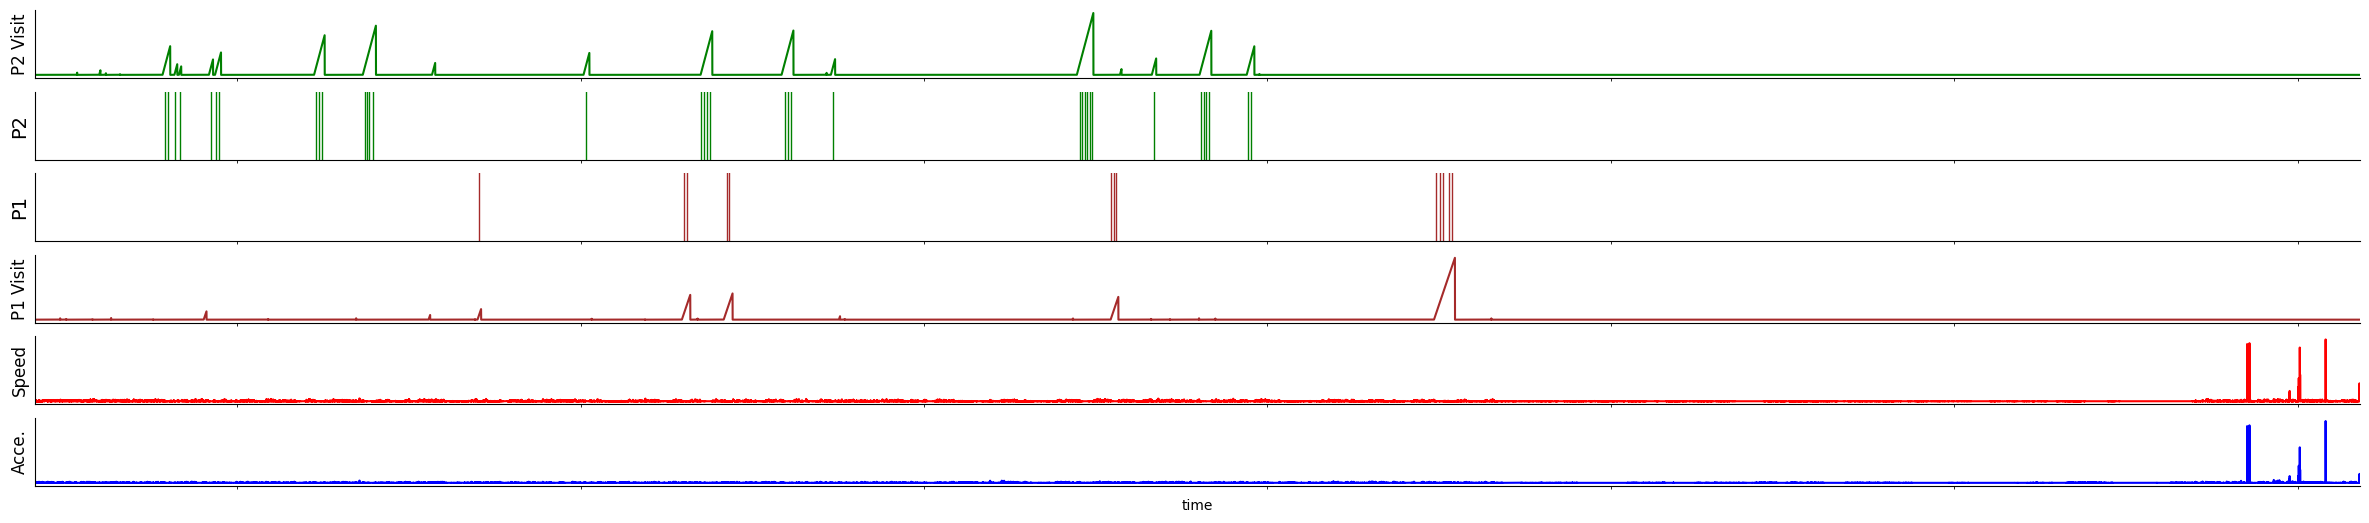

ShortSession1


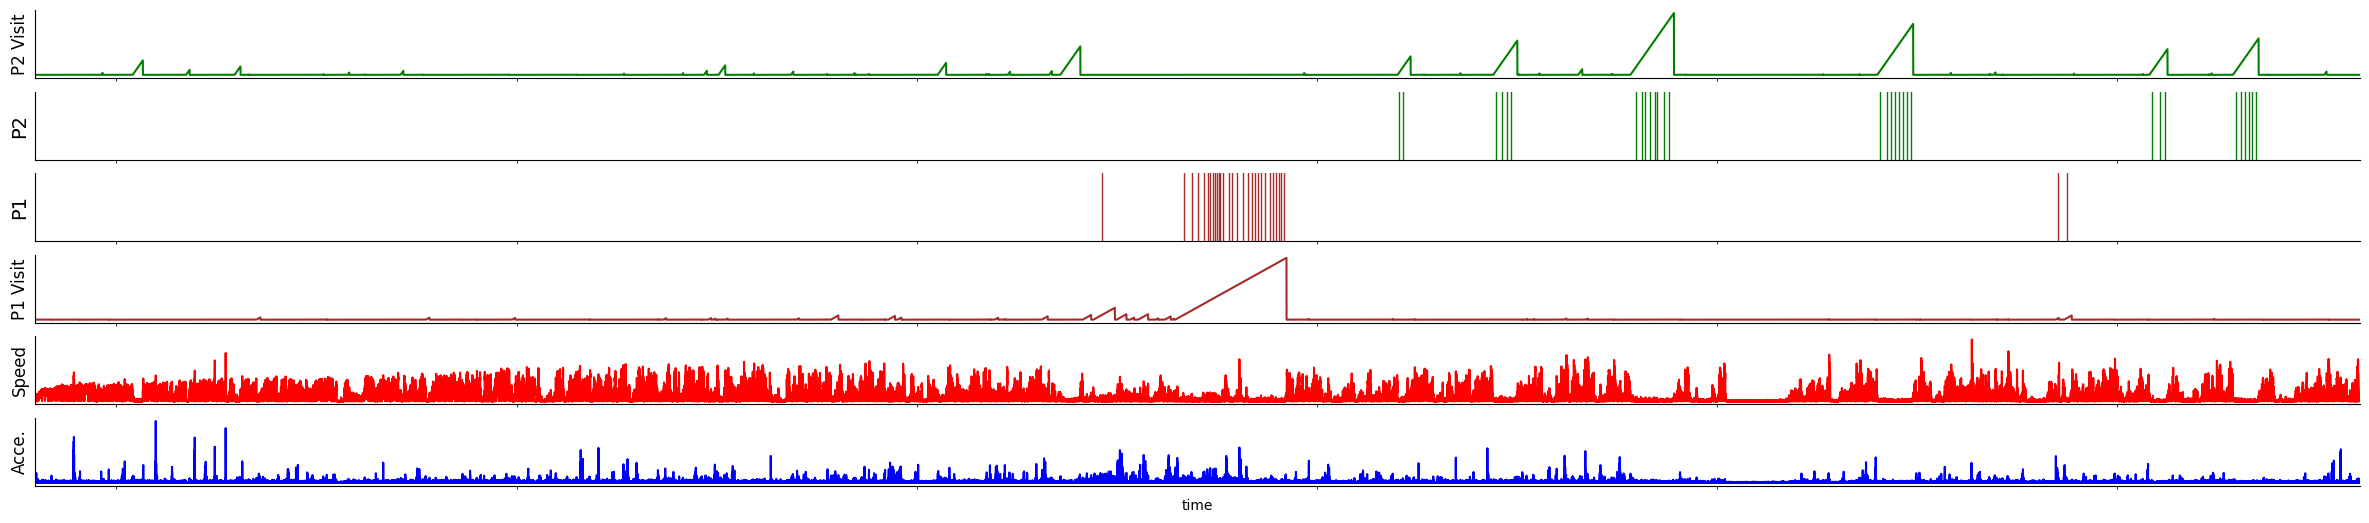

ShortSession2


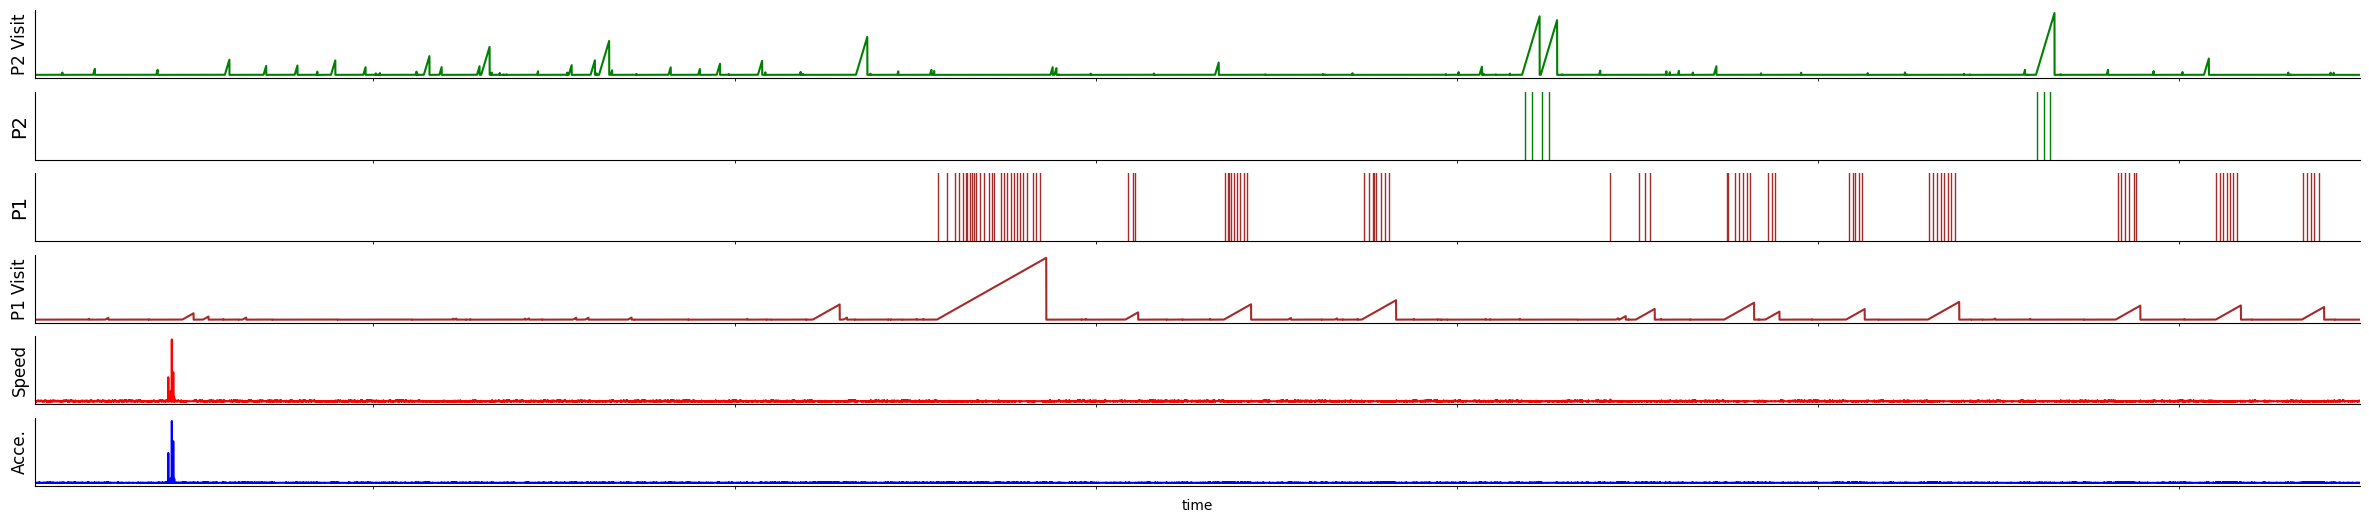

ShortSession3


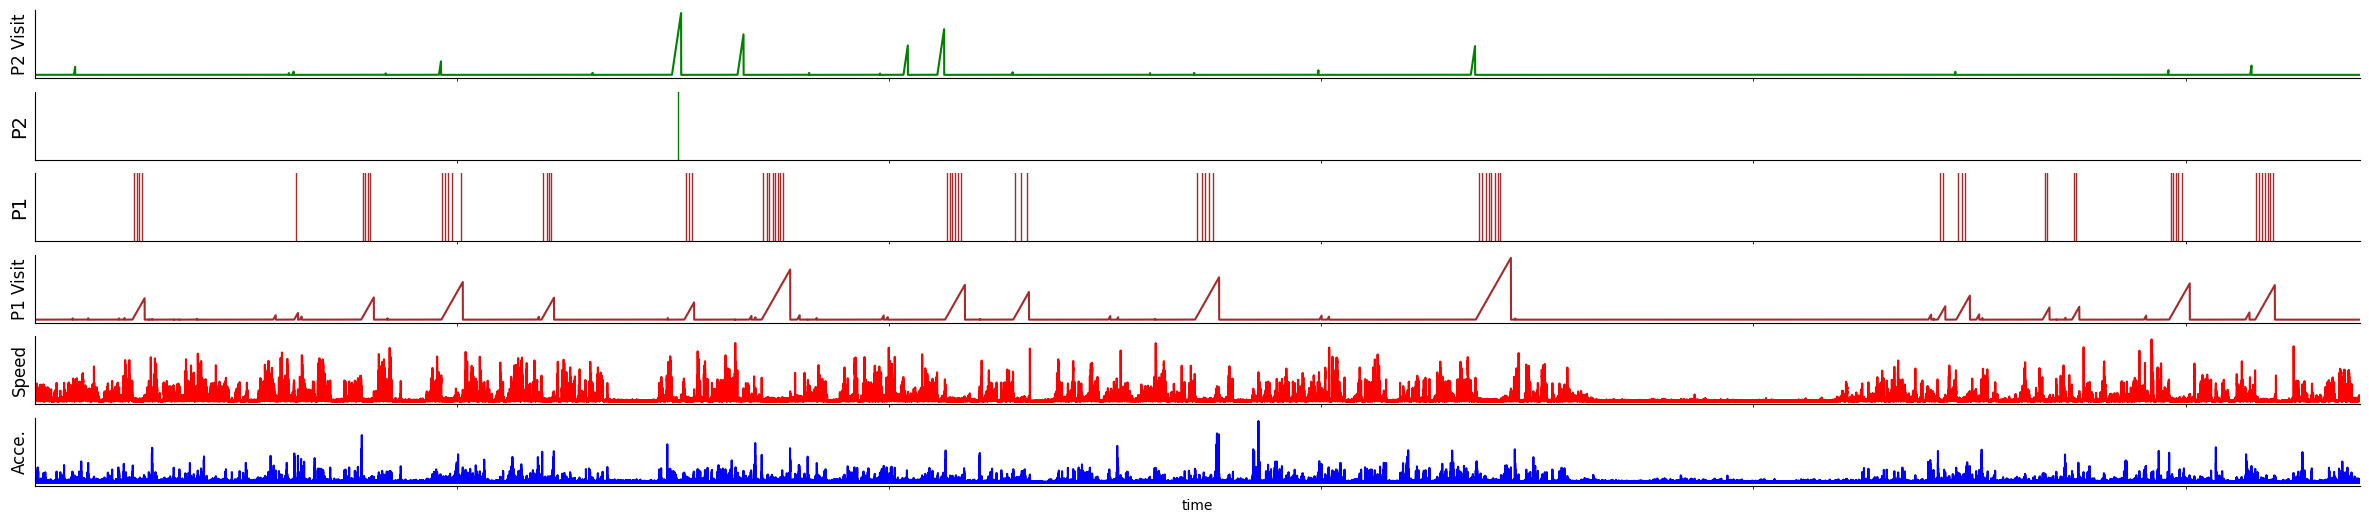

ShortSession4


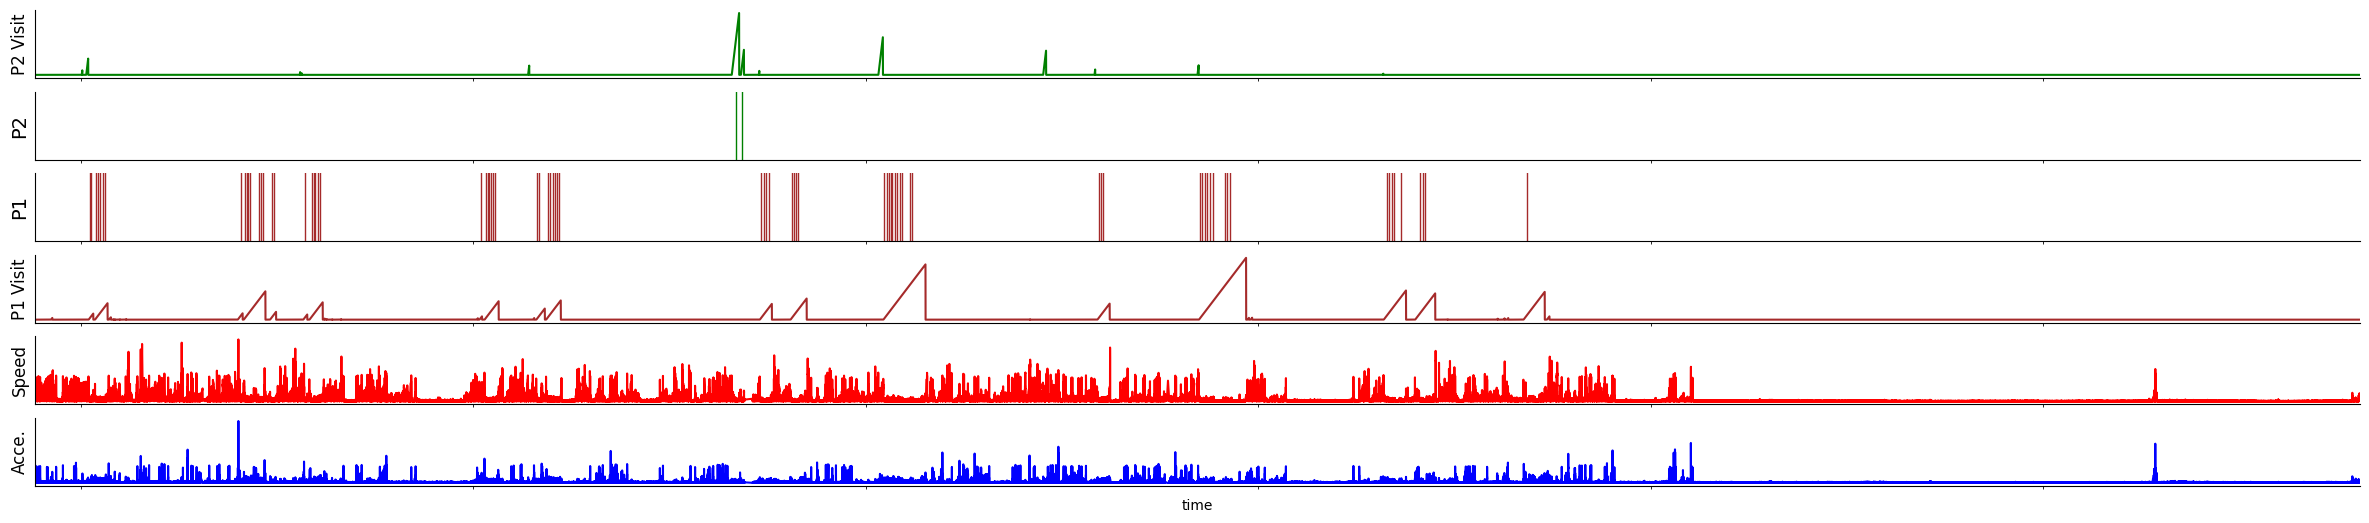

ShortSession5


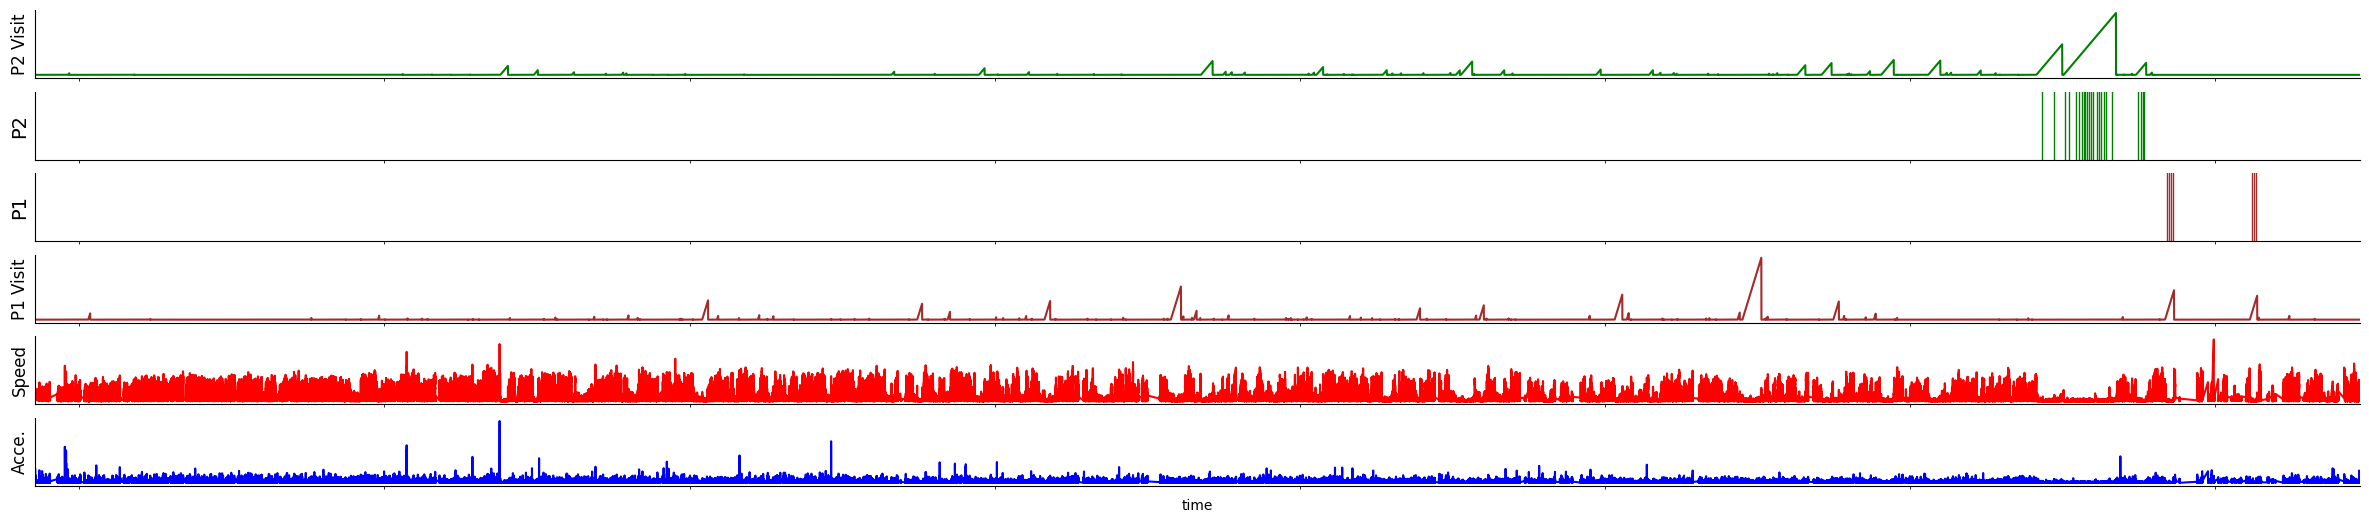

ShortSession6


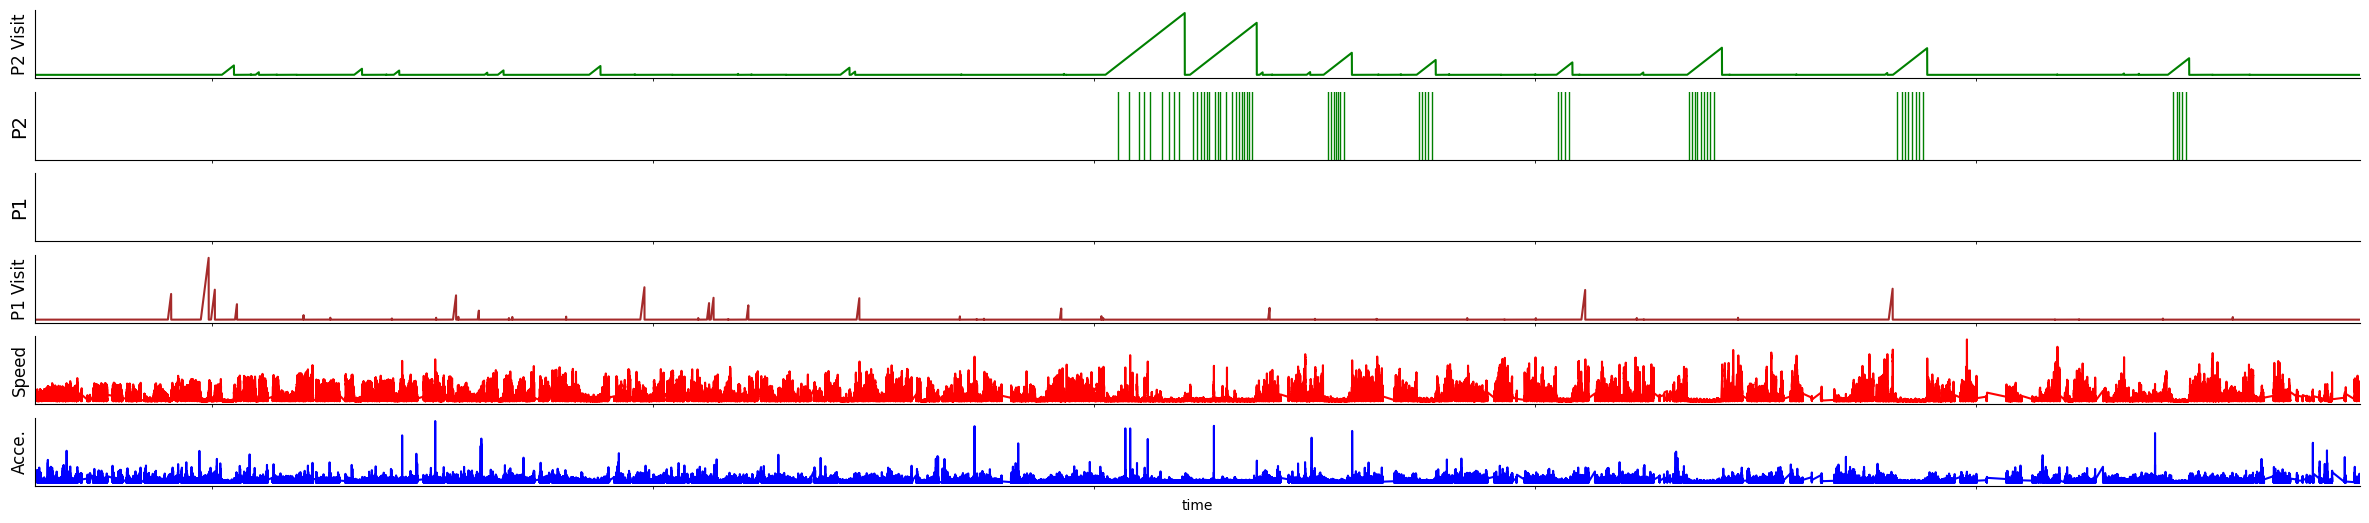

ShortSession7


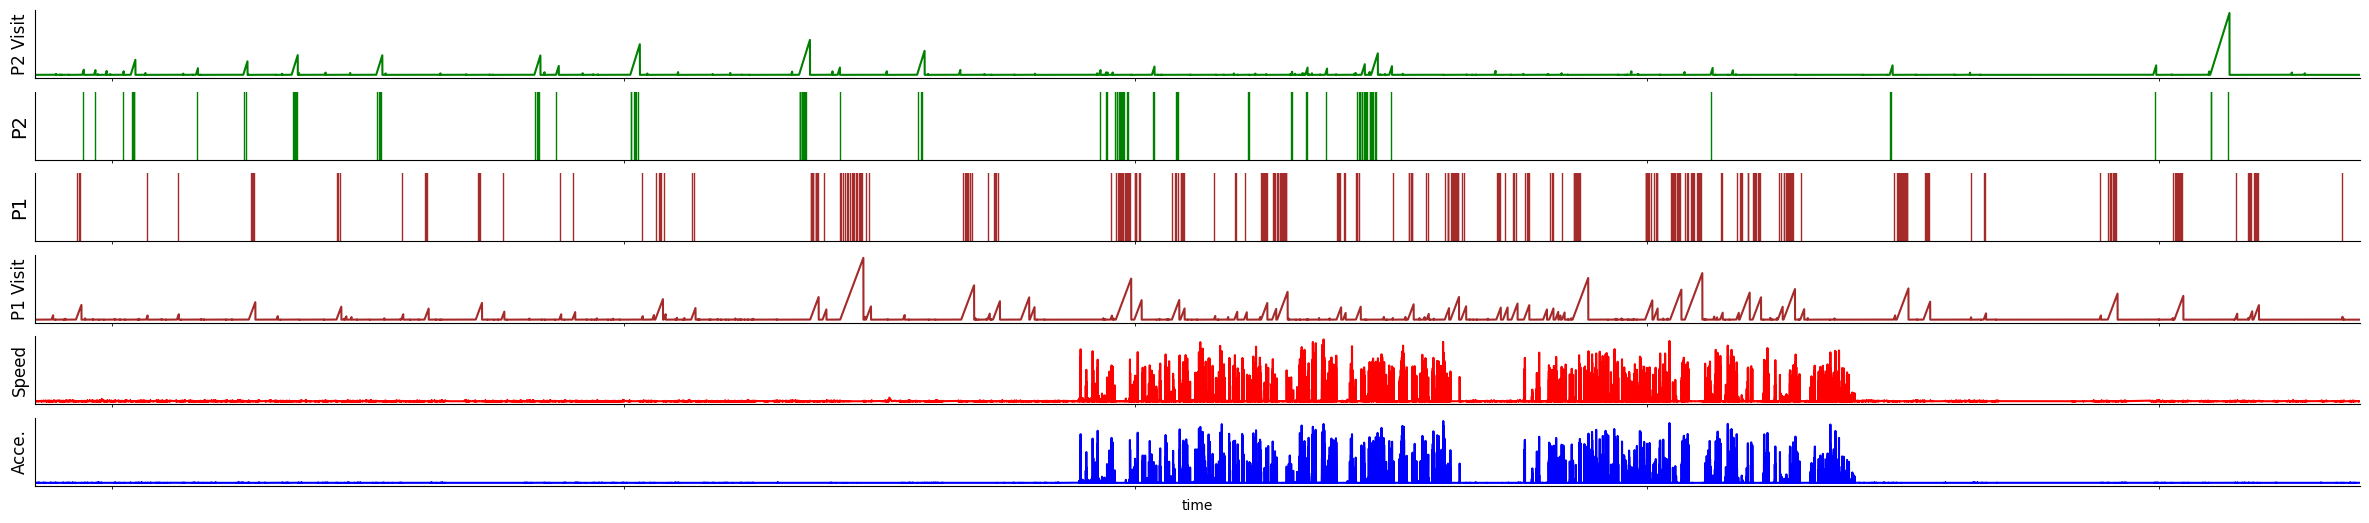

ShortSession8


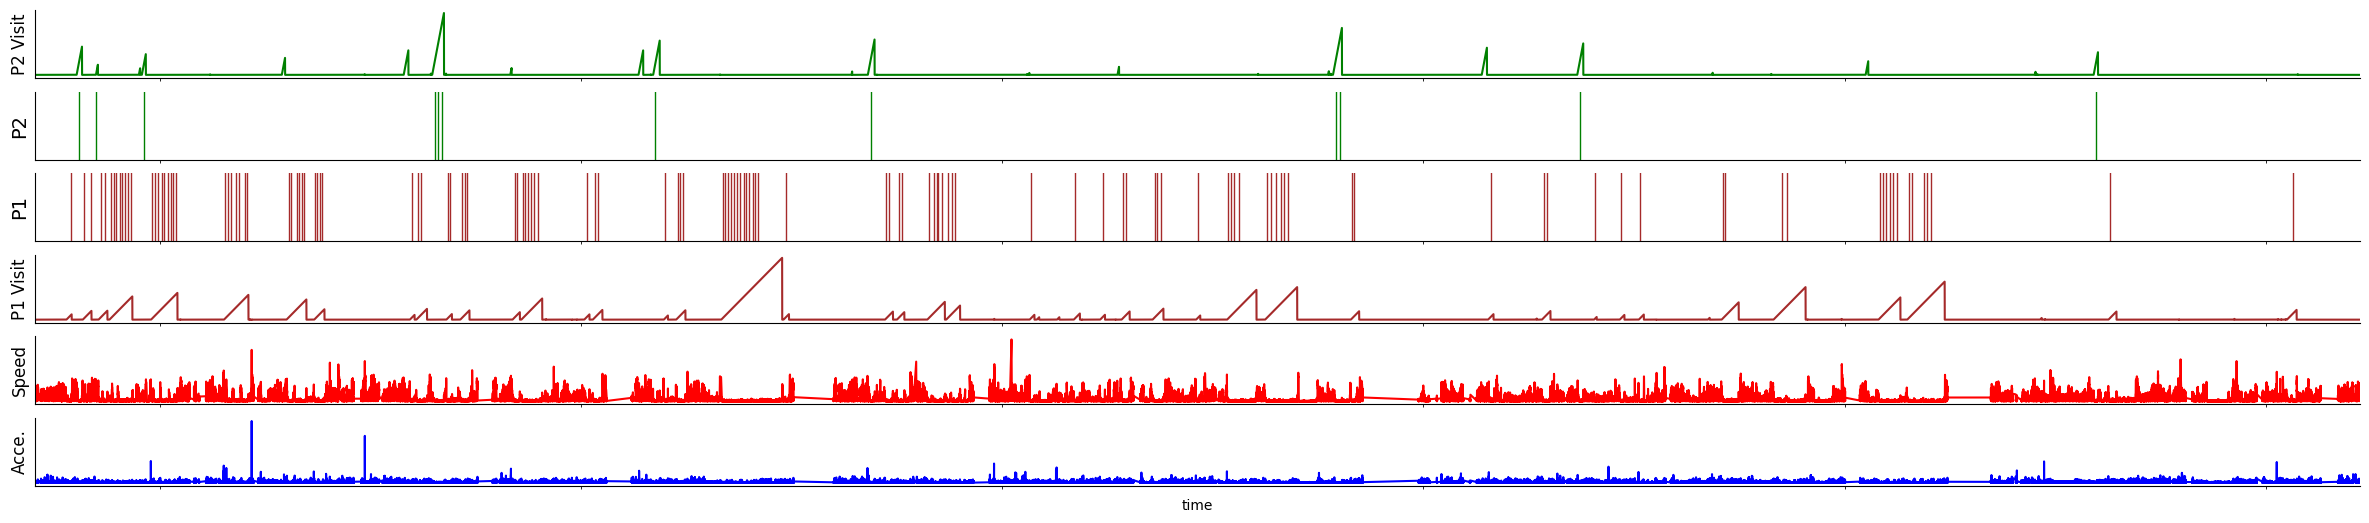

ShortSession9


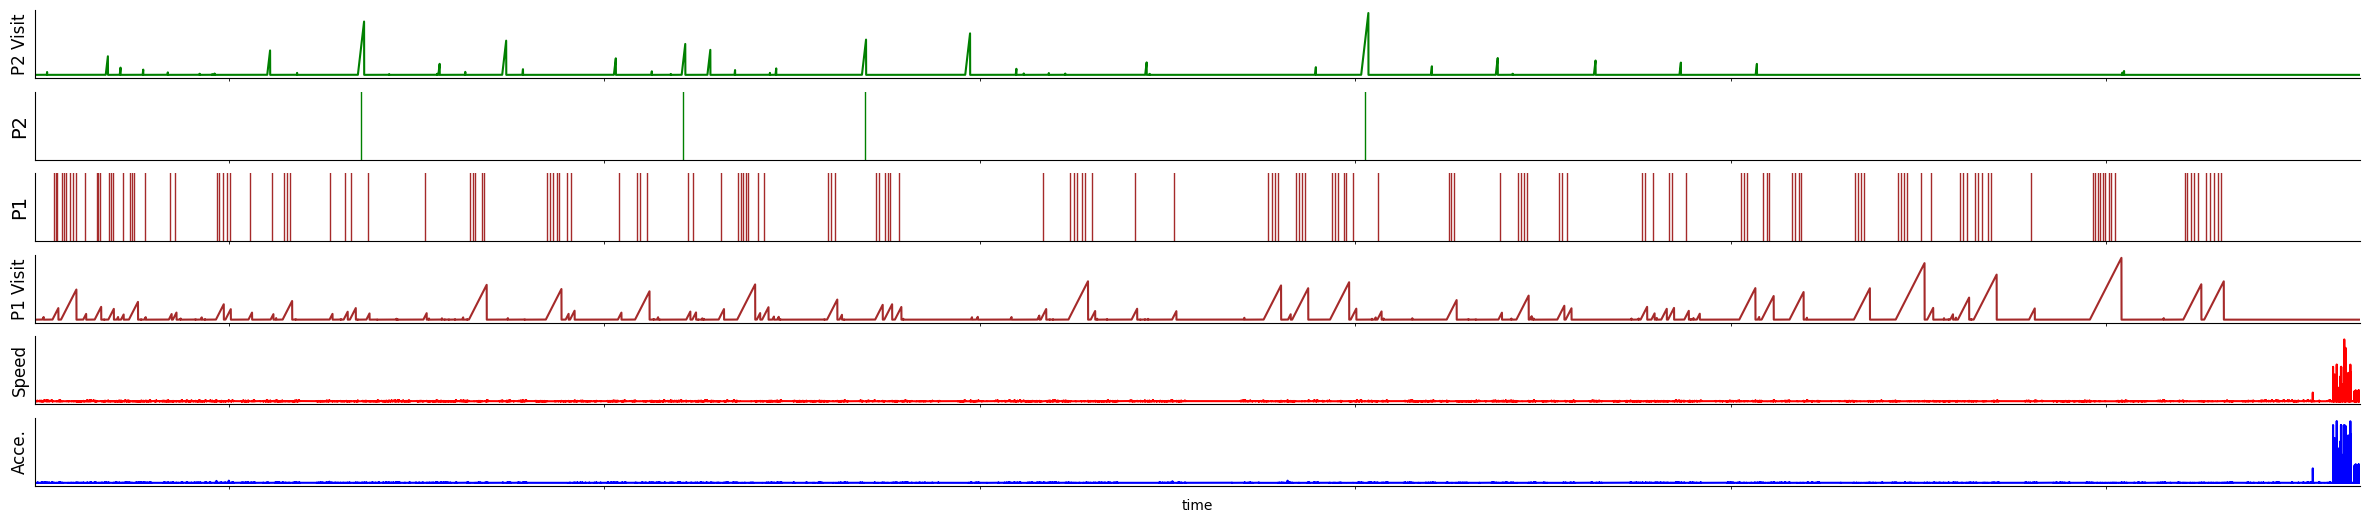

ShortSession10


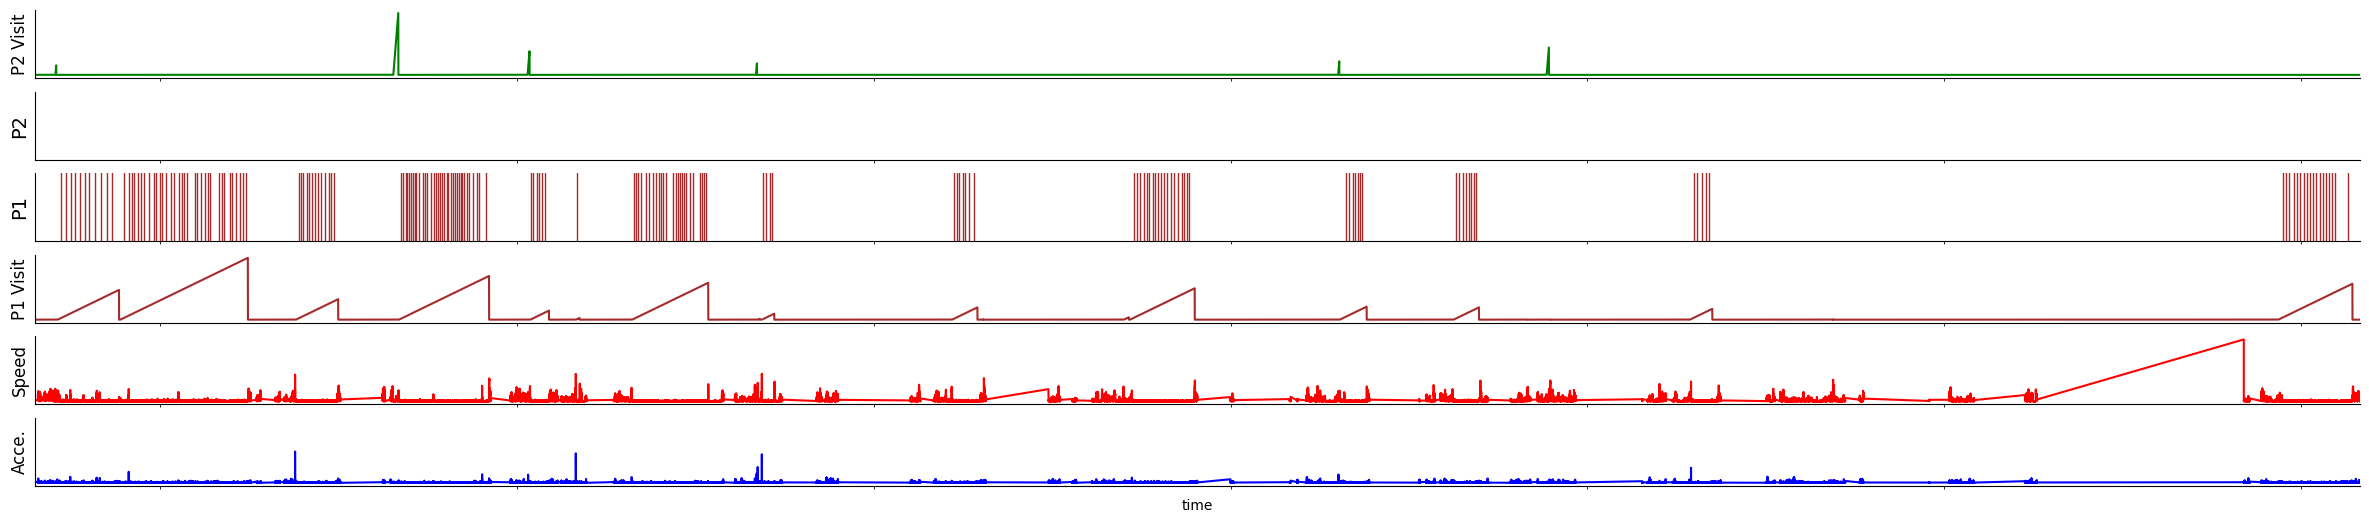

ShortSession11


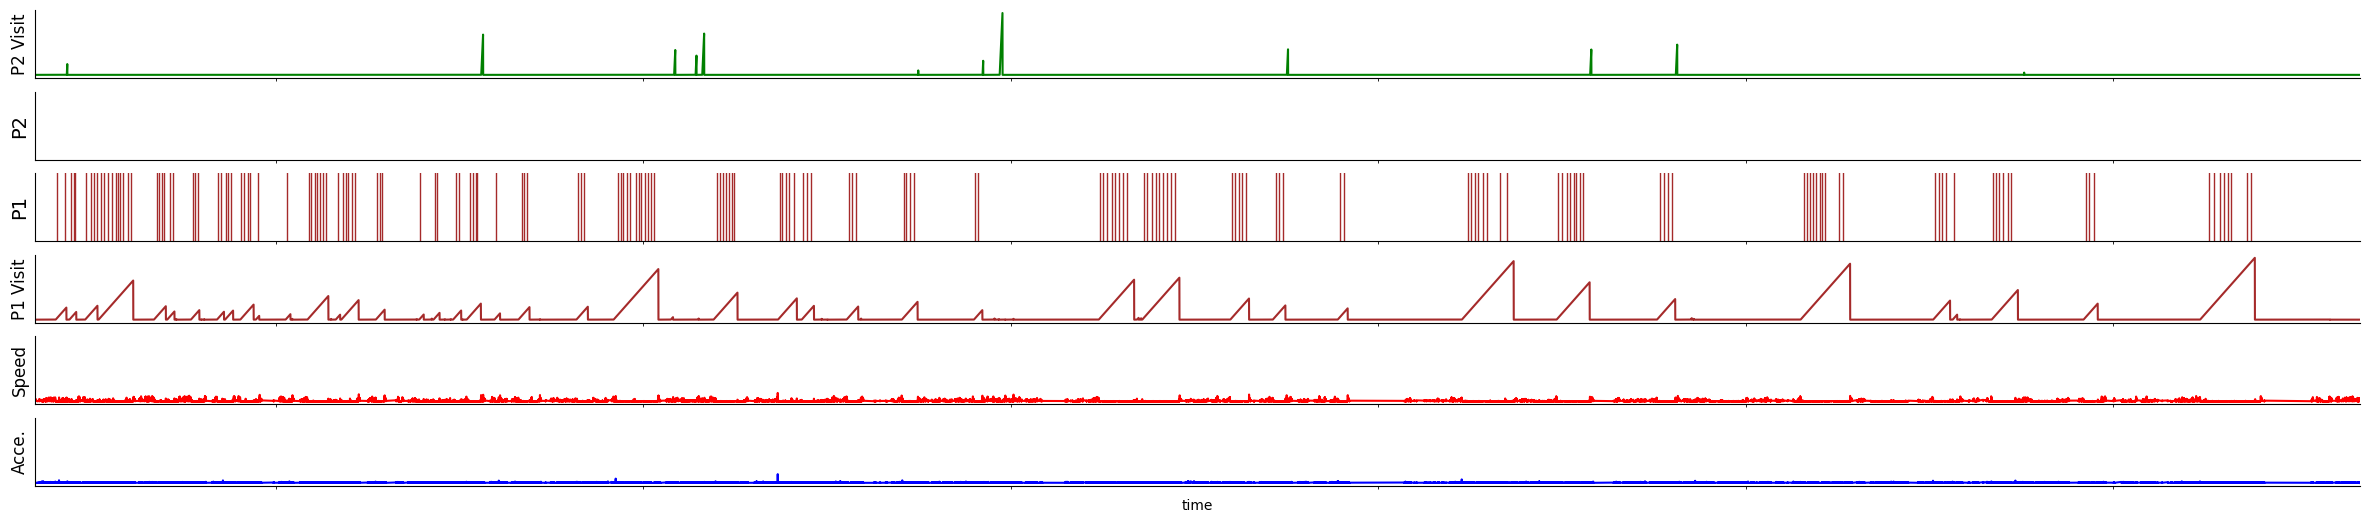

In [11]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)
        
    start, end = session.enter, session.exit
    mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        
    temp_df = mouse_pos.dropna(subset=['x', 'y'])
    first_valid_index = temp_df.index[0]
    last_valid_index = temp_df.index[-1]
    mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
        
    smoothRes = np.load(title+'smoothRes.npz')
    mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
    mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
    mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
    mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
    mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
    mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

    x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
    vel = np.sqrt(x_vel**2 + y_vel**2)
    mouse_pos['smoothed_speed'] = pd.Series(vel)
    
    x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
    acc = np.sqrt(x_acc**2 + y_acc**2)
    mouse_pos['smoothed_acceleration'] = pd.Series(acc)
    
    mouse_pos = mouse_pos.dropna(subset=['x'])
        
    InPatch(mouse_pos)
    DrawTimeInPatch(mouse_pos)

ShortSession0


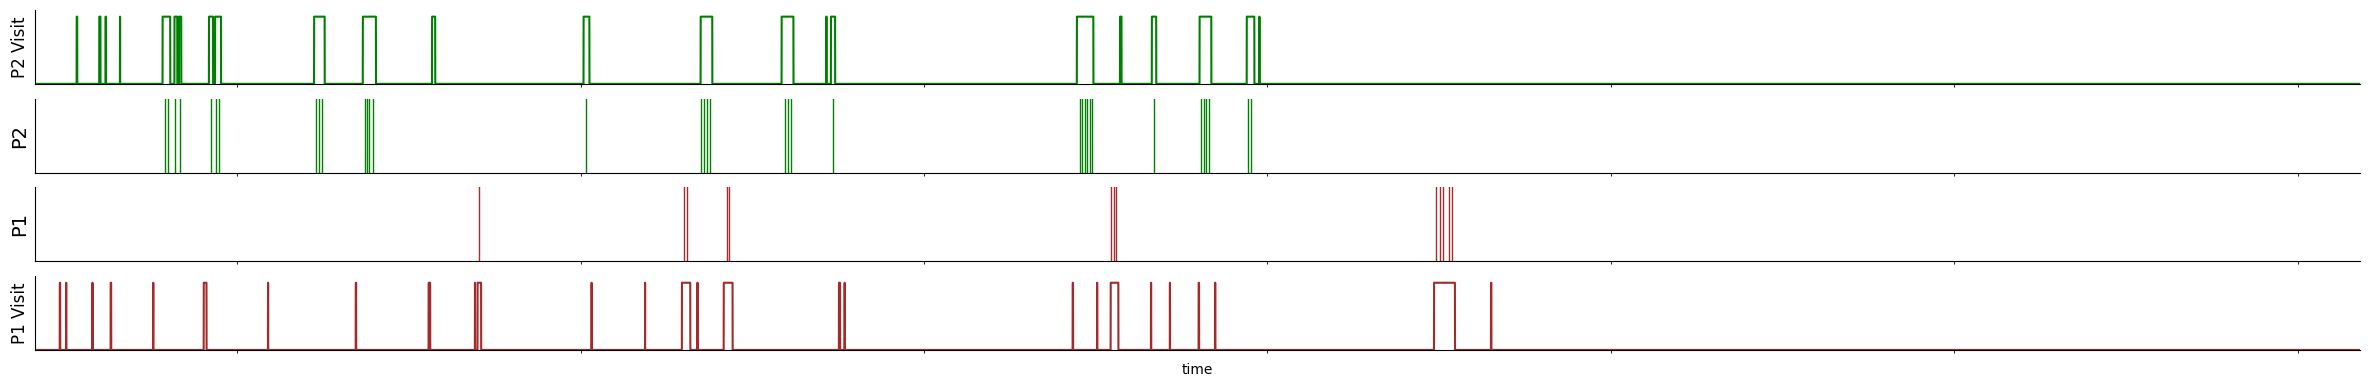

In [15]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    if i == 0:
        title = 'ShortSession'+str(i)
        print(title)
            
        start, end = session.enter, session.exit
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
            
        temp_df = mouse_pos.dropna(subset=['x', 'y'])
        first_valid_index = temp_df.index[0]
        last_valid_index = temp_df.index[-1]
        mouse_pos = mouse_pos.loc[first_valid_index:last_valid_index]
            
        smoothRes = np.load(title+'smoothRes.npz')
        mouse_pos['smoothed_position_x'] = pd.Series(smoothRes['xnN'][0][0], index=mouse_pos.index)
        mouse_pos['smoothed_position_y'] = pd.Series(smoothRes['xnN'][3][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_x'] = pd.Series(smoothRes['xnN'][1][0], index=mouse_pos.index)
        mouse_pos['smoothed_velocity_y'] = pd.Series(smoothRes['xnN'][4][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_x'] = pd.Series(smoothRes['xnN'][2][0], index=mouse_pos.index)
        mouse_pos['smoothed_acceleration_y'] = pd.Series(smoothRes['xnN'][5][0], index=mouse_pos.index)

        x_vel, y_vel = mouse_pos['smoothed_velocity_x'], mouse_pos['smoothed_velocity_y']
        vel = np.sqrt(x_vel**2 + y_vel**2)
        mouse_pos['smoothed_speed'] = pd.Series(vel)
        
        x_acc, y_acc = mouse_pos['smoothed_acceleration_x'], mouse_pos['smoothed_acceleration_y']
        acc = np.sqrt(x_acc**2 + y_acc**2)
        mouse_pos['smoothed_acceleration'] = pd.Series(acc)
        
        mouse_pos = mouse_pos.dropna(subset=['x'])
            
        InPatch(mouse_pos)
        DrawVisitInPatch(mouse_pos)